In [1]:
import numpy as np
import pandas as pd
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('emnist-balanced-train.csv', header=None)
test = pd.read_csv('emnist-balanced-test.csv', header=None)
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Now split labels and images from original dataframe.
train_data = train.iloc[:, 1:]
train_labels = train.iloc[:, 0]
test_data = test.iloc[:, 1:]
test_labels = test.iloc[:, 0]
# one hot 
#train_labels = pd.get_dummies(train_labels)
#test_labels = pd.get_dummies(test_labels)
train_labels.head()

0    45
1    36
2    43
3    15
4     4
Name: 0, dtype: int64

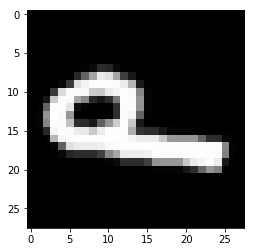

In [4]:
# Turn our Dataframes into numpy array and delete train and test to save up memory.
train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values
del train, test
# For some reason, sadly, the EMNIST dataset was rotated and flipped and we need fix that.
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(train_data[45].reshape([28, 28]), cmap='Greys_r')
plt.show()

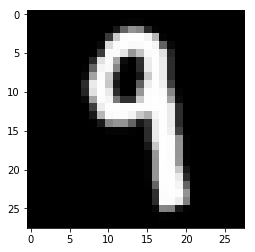

In [5]:
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28,28,1])
    
train_data = np.apply_along_axis(rotate, 1, train_data)/255
test_data = np.apply_along_axis(rotate, 1, test_data)/255

plt.imshow(train_data[45].reshape([28, 28]), cmap='Greys_r')
plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
#from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
#from torchvision.utils import make_grid

In [7]:
class mydata(Dataset):
     def __init__(self, data, label, transform = transforms.Compose([transforms.ToTensor()])):
        self.transform = transform
        self.data = data
        self.label = label
        pass
    
     def __len__(self):
        return len(self.data)

     def __getitem__(self, idx):
        return self.transform(self.data[idx].astype(np.double)), self.label[idx].astype(np.double)

In [8]:
batch_size = 64
train_dataset = mydata(train_data,train_labels)
test_dataset = mydata(test_data, test_labels)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, shuffle=False)

In [9]:
num_classes=47
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),          
            nn.MaxPool2d(kernel_size=2, stride=2),
            

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),          
            nn.Dropout(p = 0.2),  
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),          
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.3),
            nn.Linear(576, 100),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.3),
            nn.Linear(100, num_classes)
        )    
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x   

In [10]:
model = Net().double()
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [11]:
print(model)

Net(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace)
    (2): Dropout(p=0.2)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace)
    (11): Dropout(p=0.2)
    (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.3)
    (1): Linear(in_features=576, out_features=100, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.3)
    (4): Linear(in_features=100, out_feature

In [16]:
def train(epoch=10):
    model.train()
    exp_lr_scheduler.step()

    for batch_idx, (data, target) in enumerate(train_loader):
        #data, target = Variable(data), Variable(target)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.long())
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss))


In [17]:
train()

Train Epoch: 10 [3200/112800 (3%)]	Loss: 2.741386
Train Epoch: 10 [6400/112800 (6%)]	Loss: 2.253186
Train Epoch: 10 [9600/112800 (9%)]	Loss: 2.032215
Train Epoch: 10 [12800/112800 (11%)]	Loss: 1.830560
Train Epoch: 10 [16000/112800 (14%)]	Loss: 1.663009
Train Epoch: 10 [19200/112800 (17%)]	Loss: 1.445842
Train Epoch: 10 [22400/112800 (20%)]	Loss: 1.131125
Train Epoch: 10 [25600/112800 (23%)]	Loss: 0.984219
Train Epoch: 10 [28800/112800 (26%)]	Loss: 1.031029
Train Epoch: 10 [32000/112800 (28%)]	Loss: 1.004440
Train Epoch: 10 [35200/112800 (31%)]	Loss: 1.215285
Train Epoch: 10 [38400/112800 (34%)]	Loss: 0.926013
Train Epoch: 10 [41600/112800 (37%)]	Loss: 1.282806
Train Epoch: 10 [44800/112800 (40%)]	Loss: 0.798903
Train Epoch: 10 [48000/112800 (43%)]	Loss: 0.829936
Train Epoch: 10 [51200/112800 (45%)]	Loss: 1.219324
Train Epoch: 10 [54400/112800 (48%)]	Loss: 0.852634
Train Epoch: 10 [57600/112800 (51%)]	Loss: 0.682416
Train Epoch: 10 [60800/112800 (54%)]	Loss: 1.058772
Train Epoch: 10 [6

In [23]:
n_epochs = 20
for epoch in range(n_epochs):
    train(epoch)
    evaluate(train_loader)

KeyboardInterrupt: 

# evaluation

In [51]:
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss += F.cross_entropy(output, target.long(), size_average=False)
        pred = torch.argmax(output, dim=1)
        correct += torch.sum(torch.eq(pred,target.long()))
        loss /= len(data_loader.dataset)

        print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
            loss, correct, len(data_loader.dataset),
            100. * correct / len(data_loader.dataset)))

In [52]:
evaluate(test_loader)

/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average loss: 0.0021, Accuracy: 52/18800 (0.000%)


Average loss: 0.0015, Accuracy: 108/18800 (0.000%)


Average loss: 0.0015, Accuracy: 161/18800 (0.000%)


Average loss: 0.0014, Accuracy: 216/18800 (1.000%)


Average loss: 0.0021, Accuracy: 271/18800 (1.000%)


Average loss: 0.0026, Accuracy: 319/18800 (1.000%)


Average loss: 0.0015, Accuracy: 373/18800 (1.000%)


Average loss: 0.0018, Accuracy: 424/18800 (2.000%)


Average loss: 0.0033, Accuracy: 473/18800 (2.000%)


Average loss: 0.0020, Accuracy: 523/18800 (2.000%)


Average loss: 0.0017, Accuracy: 577/18800 (3.000%)


Average loss: 0.0015, Accuracy: 632/18800 (3.000%)


Average loss: 0.0018, Accuracy: 689/18800 (3.000%)


Average loss: 0.0014, Accuracy: 747/18800 (3.000%)


Average loss: 0.0014, Accuracy: 802/18800 (4.000%)


Average loss: 0.0018, Accuracy: 852/18800 (4.000%)


Average loss: 0.0013, Accuracy: 908/18800 (4.000%)


Average loss: 0.0021, Accuracy: 955/18800 (5.000%)


Average loss: 0.0019, Accuracy: 1008/18800 (5.


Average loss: 0.0013, Accuracy: 7940/18800 (42.000%)


Average loss: 0.0016, Accuracy: 7994/18800 (42.000%)


Average loss: 0.0011, Accuracy: 8052/18800 (42.000%)


Average loss: 0.0015, Accuracy: 8102/18800 (43.000%)


Average loss: 0.0024, Accuracy: 8154/18800 (43.000%)


Average loss: 0.0016, Accuracy: 8209/18800 (43.000%)


Average loss: 0.0018, Accuracy: 8260/18800 (43.000%)


Average loss: 0.0018, Accuracy: 8314/18800 (44.000%)


Average loss: 0.0023, Accuracy: 8364/18800 (44.000%)


Average loss: 0.0016, Accuracy: 8419/18800 (44.000%)


Average loss: 0.0016, Accuracy: 8471/18800 (45.000%)


Average loss: 0.0014, Accuracy: 8526/18800 (45.000%)


Average loss: 0.0022, Accuracy: 8576/18800 (45.000%)


Average loss: 0.0017, Accuracy: 8631/18800 (45.000%)


Average loss: 0.0019, Accuracy: 8686/18800 (46.000%)


Average loss: 0.0015, Accuracy: 8738/18800 (46.000%)


Average loss: 0.0020, Accuracy: 8791/18800 (46.000%)


Average loss: 0.0023, Accuracy: 8839/18800 (47.000%)


Average l

# error analyze

In [14]:
id_name = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',
        8:'8',9:'9',10 :"A",11 :"B",12 :"C",13 :"D",14 :"E",15 :"F",
        16 :"G",17 :"H",18 :"I",19 :"J",20 :"K",21 :"L",22 :"M",
        23 :"N",24 :"O",25 :"P",26 :"Q",27 :"R",28 :"S",29 :"T",
        30 :"U",31 :"V",32 :"W",33 :"X",34 :"Y",35 :"Z",36 :"a",
        37:"b",38:"d",39:"e",40:"f",41:"g",42:"h",43:"n",44:"q",
        45:"r",46:"t"
}

In [10]:
len(train_labels)*0.9

101520.0

In [11]:
prediction = model.predict(train_data[101520:])

In [12]:
for i in range(101520,101520+1000):
    if np.argmax(prediction[i-101520])!=np.argmax(train_labels[i]):
        print(i)

101534
101544
101545
101549
101556
101568
101572
101597
101599
101602
101605
101608
101609
101634
101637
101640
101649
101653
101654
101656
101666
101672
101701
101702
101704
101712
101724
101735
101742
101743
101745
101760
101765
101784
101788
101805
101817
101842
101851
101853
101857
101871
101879
101887
101891
101898
101907
101916
101928
101931
101932
101936
101941
101944
101952
101983
101996
101997
102008
102009
102010
102022
102023
102025
102031
102039
102046
102050
102051
102056
102064
102065
102068
102073
102074
102095
102102
102103
102106
102108
102111
102113
102121
102129
102141
102153
102159
102164
102176
102183
102209
102217
102235
102238
102254
102259
102262
102268
102283
102287
102309
102310
102319
102328
102337
102345
102350
102357
102372
102373
102377
102387
102400
102402
102408
102415
102438
102442
102447
102448
102468
102476
102479
102497
102501
102509
102515
102517


Label: F
pre： F


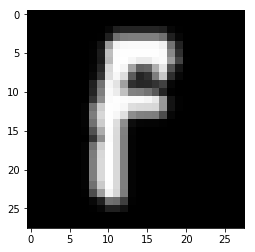

In [15]:
idx = 101830
plt.imshow(train_data[idx][:,:,0],cmap='gray')
print("Label:",id_name[np.argmax(train_labels[idx])])
print("pre：",id_name[np.argmax(prediction[idx-101520])])

1


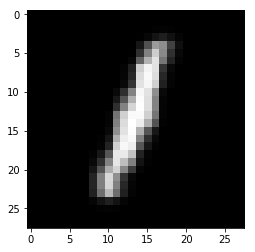

In [16]:
idx = 9
plt.imshow(train_data[idx][:,:,0],cmap='gray')
print(id_name[np.argmax(train_labels[idx])])
#print(np.argmax(train_labels[idx])-10)

In [1]:
tmp = plt.imread("./real/j.png")[:,:,0]
plt.imshow(1.0*(tmp<0.5), cmap='gray')

NameError: name 'plt' is not defined

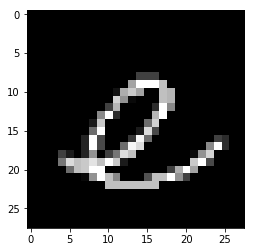

In [24]:
txtt = 1.0*(tmp<0.5)
txtt = cv2.resize(txtt, (28, 28))
plt.imshow(txtt,cmap='gray')

In [4]:
import glob
real_test= glob.glob("./real/*")
print(real_test)


test_R_1 = []    
for e in real_test:
    tmp = plt.imread(e)[:,:,0]
    tmp = 1.0*(tmp<0.67)
    sss =  cv2.resize(tmp, (28, 28))
    sss = 1.0*(sss>0.01)
    sss = sss.reshape(28,28,1)
    test_R_1.append(sss)
    
test_R_2 = []    
for e in real_test:
    tmp = plt.imread(e)[:,:,0]
    tmp = 1.0*(tmp<0.37)
    sss =  cv2.resize(tmp, (28, 28))
    sss = 1.0*(sss>0.01)
    sss = sss.reshape(28,28,1)
    test_R_2.append(sss)

['./real/3.png', './real/6.png', './real/7.png', './real/A.png', './real/B.png', './real/e.png', './real/h.png', './real/j.png', './real/k.png', './real/m.png', './real/p.png', './real/Q.png', './real/R.png', './real/w.png', './real/x.png', './real/z.png']


In [49]:
preR_1 = model.predict(np.array(test_R_1))
preR_2 = model.predict(np.array(test_R_2))

In [50]:
for i in range(len(preR_1)):
    print("pre 0.67：",id_name[np.argmax(preR_1[i])], "pre 0.37：",id_name[np.argmax(preR_2[i])])

pre 0.67： 3 pre 0.37： 3
pre 0.67： 6 pre 0.37： 6
pre 0.67： 7 pre 0.37： 7
pre 0.67： A pre 0.37： A
pre 0.67： B pre 0.37： B
pre 0.67： e pre 0.37： e
pre 0.67： h pre 0.37： h
pre 0.67： G pre 0.37： G
pre 0.67： B pre 0.37： K
pre 0.67： M pre 0.37： M
pre 0.67： P pre 0.37： P
pre 0.67： Q pre 0.37： Q
pre 0.67： A pre 0.37： R
pre 0.67： 1 pre 0.37： W
pre 0.67： X pre 0.37： X
pre 0.67： Z pre 0.37： Z


In [263]:
print("pre：",id_name[np.argmax(preR[8])])

pre： A


In [2]:
plt.imshow(test_R_1[11][:,:,0])

NameError: name 'plt' is not defined

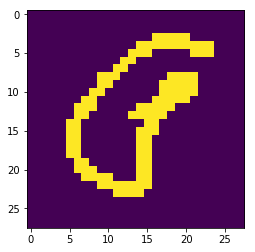

In [6]:
plt.imshow(test_R_2[7][:,:,0])